# Task 2.4 - Concentric sampled deformation gradients

## Setup

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.rcParams['text.usetex'] = True
sns.set_style('darkgrid')

from typing import Literal
from keras import optimizers
from keras import losses
from keras import metrics
from pprint import pprint

from src.models import CustomFFNN
from src.data_import import load_paml_dataset, load_data, load_df, load_train_test_concentric
from src.plots import plot_stress_predictions, plot_energy_prediction, plot_loss, plot_heatmap
from src.utils import get_scores
from src.analytic_potential import get_C_features
from src.predict_utils import predict_multi_cases_PANN, predict_identity_F_PANN, predict_multi_cases_naive

2024-12-03 15:50:26.155726: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:50:26.159086: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-03 15:50:26.170503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-03 15:50:26.195477: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-03 15:50:26.200879: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-03 15:50:26.214044: I tensorflow/core/platform/cpu_feature_gu

### Paths

In [2]:
# Calibration paths
data_dir = os.path.abspath('concentric')

### Load Datasets

In [ ]:
train_data, test_data = load_train_test_concentric(data_dir)

train_F = tf.concat([tup[0] for tup in train_data], axis=0)
train_P = tf.concat([tup[1] for tup in train_data], axis=0)
train_W = tf.concat([tup[2] for tup in train_data], axis=0)

## Calibrate Naive NN on more data

In [ ]:
naive_features = get_C_features(train_F)
naive_labels = tf.reshape(train_P, (-1, 9))

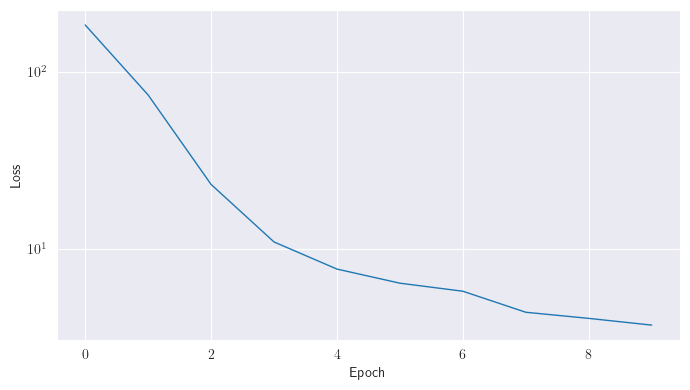

In [6]:
naive_model = CustomFFNN(
    hidden_sizes=[32, 32, 32, 9],
    activations=['softplus', 'softplus', 'softplus', 'linear']
)
naive_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),
    loss=losses.MeanSquaredError()
)
naive_h = naive_model.fit(naive_features, naive_labels, batch_size=16, epochs=10, verbose=0)
naive_loss = naive_h.history['loss']
plot_loss(naive_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


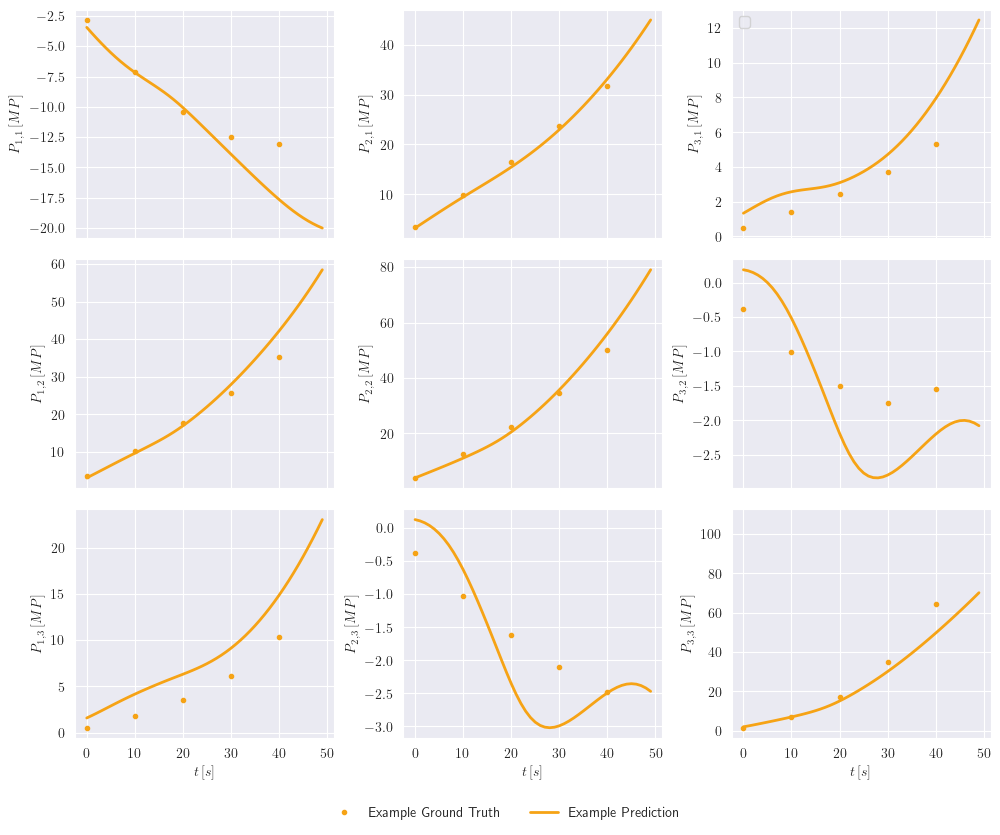

In [ ]:
P_naive_test_labels, P_naive_test_preds = predict_multi_cases_naive(naive_model, test_one_FWP_tup)
plot_stress_predictions(
    {'Example': test_case_P.numpy().reshape(-1, 9)}, 
    {'Example': train_case_P}
)